In [9]:
import sys
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from tqdm import tqdm
from matplotlib import pyplot as plt

sys.path.append("..")

from src.preprocessing.data_loader import load_data

# Data Loading

In [3]:
train_user_interaction, user_items = load_data("../dataset/yelp2018/train.txt")
train_user_interaction

,user_id,item_id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
1237254,31667,22984
1237255,31667,12943
1237256,31667,29149
1237257,31667,4927


In [4]:
user_count, item_count = train_user_interaction["user_id"].nunique(), train_user_interaction["item_id"].nunique()
user_count, item_count

(31668, 38048)

In [5]:
item_set = train_user_interaction["item_id"].unique()
item_set = [int(item_id) for item_id in item_set]

In [6]:
random_negative, = random.sample(item_set, k=1)
random_negative

24721

# Model Definition

In [7]:
user_embedding_layer = keras.layers.Embedding(user_count, 8)
item_embedding_layer = keras.layers.Embedding(item_count, 8)

# Model Training

In [8]:
NEPOCH = 5
BATCH_SIZE = 512
LEARNING_RATE = 0.01

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_epoch_history = []
loss_batch_history = []
for epoch in range(NEPOCH):
    batch_loss = []
    with tqdm(total=len(train_user_interaction)) as pbar:
        for start_idx in range(0, len(train_user_interaction), BATCH_SIZE):
            user_id = train_user_interaction["user_id"][start_idx:(start_idx + BATCH_SIZE)]
            item_id = train_user_interaction["item_id"][start_idx:(start_idx + BATCH_SIZE)]

            # random negative sample
            random_negative = []
            for uid in user_id:
                sampled_item, = random.sample(item_set, k=1)
                while sampled_item in user_items[uid]:
                    sampled_item, = random.sample(item_set, k=1)
                sampled_item = np.int64(sampled_item)
                random_negative.append(sampled_item)
            user_id = tf.constant(user_id)
            item_id = tf.constant(item_id)
            random_negative = tf.constant(random_negative)

            # forward propagation
            with tf.GradientTape() as tape:
                user_embedding = user_embedding_layer(user_id)
                item_embedding = item_embedding_layer(item_id)
                negative_embedding = item_embedding_layer(random_negative)

                positive_prediction = tf.reduce_sum(user_embedding * item_embedding, axis=-1)
                negative_prediction = tf.reduce_sum(user_embedding * negative_embedding, axis=-1)

                loss_value = tf.reduce_mean(-tf.math.log(tf.sigmoid(positive_prediction - negative_prediction)))

            # calculate gradient
            user_gradient, item_gradient = tape.gradient(loss_value, user_embedding_layer.trainable_variables + item_embedding_layer.trainable_variables)

            # back propagation
            optimizer.apply_gradients(zip([user_gradient, item_gradient], user_embedding_layer.trainable_variables + item_embedding_layer.trainable_variables))

            loss_batch_history.append(float(loss_value))
            batch_loss.append(float(loss_value))

            pbar.update(len(item_id))
            pbar.set_postfix({"loss": float(loss_value)})
    
    loss_epoch_history.append(float(tf.reduce_mean(batch_loss)))

100%|██████████| 1237259/1237259 [00:35<00:00, 34382.64it/s, loss=0.128] 


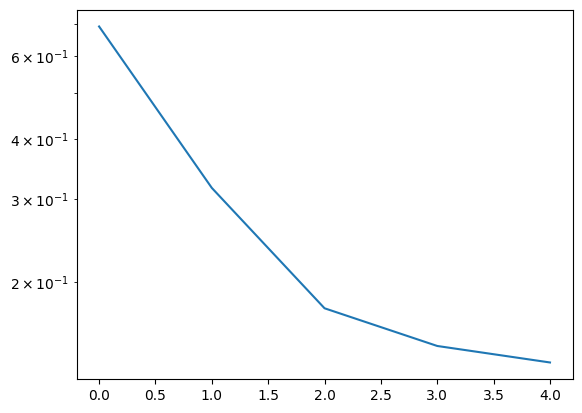

In [12]:
plt.plot(loss_epoch_history)
plt.yscale("log")
plt.show()

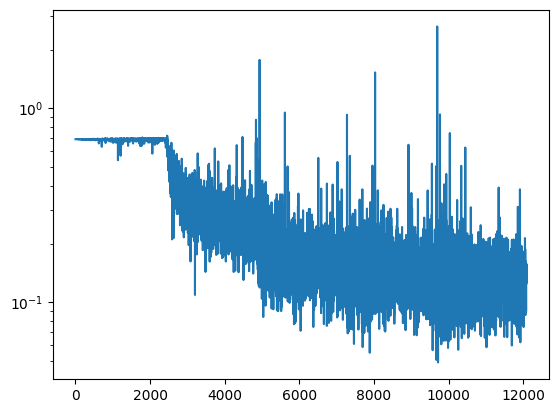

In [13]:
plt.plot(loss_batch_history)
plt.yscale("log")
plt.show()

# Archive

In [ ]:
NEPOCH = 1
BATCH_SIZE = 512
LEARNING_RATE = 0.01

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_history = []
for epoch in range(NEPOCH):
    for idx, row in tqdm(train_user_interaction.iterrows(), total=len(train_user_interaction)):
        user_id, item_id = row["user_id"], row["item_id"]

        # random negative sample
        random_negative, = random.sample(item_set, k=1)
        while random_negative in user_items[user_id]:
            random_negative, = random.sample(item_set, k=1)
        random_negative = np.int64(random_negative)

        # forward propagation
        with tf.GradientTape() as tape:
            user_embedding = user_embedding_layer(user_id)
            item_embedding = item_embedding_layer(item_id)
            negative_embedding = item_embedding_layer(random_negative)

            positive_prediction = tf.reduce_sum(user_embedding * item_embedding)
            negative_prediction = tf.reduce_sum(user_embedding * negative_embedding)

            loss_value = -tf.math.log(tf.sigmoid(positive_prediction - negative_prediction))

        # calculate gradient
        user_gradient, item_gradient = tape.gradient(loss_value, user_embedding_layer.trainable_variables + item_embedding_layer.trainable_variables)

        # back propagation
        optimizer.apply_gradients(zip([user_gradient, item_gradient], user_embedding_layer.trainable_variables + item_embedding_layer.trainable_variables))